In [1]:
# Importing all the required packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from scipy.stats import randint, uniform
from joblib import dump, load


In [2]:
# The dataset in kaggle https://www.kaggle.com/datasets/soulaimanebenayad/united-states-redfin-housing-market-csv
# had two MN datasets in separate csv
# I am combining both and saving it into a new file called housing_data.csv
df1 = pd.read_csv("MN-1.csv")
df2 = pd.read_csv("MN-2.csv")

combined_df = pd.concat([df1, df2], ignore_index=True)

# Saved to a new CSV
combined_df.to_csv("housing_data.csv", index=False)


In [3]:
# Loading the dataset using pandas
# Read the combined CSV created earlier (MN-1 + MN-2)
housing_raw = pd.read_csv("housing_data.csv")

# Renaming some of the columns for consistency
# Match names with assignment's requirements and convert all to lowercase with underscores
housing_raw = housing_raw.rename(columns={
    'PRICE': 'median_house_value',     # target variable
    'LATITUDE': 'latitude',            # geographic coordinate
    'LONGITUDE': 'longitude',          # geographic coordinate
    'YEAR BUILT': 'housing_median_age' # approximate median housing age
})
housing_raw.columns = housing_raw.columns.str.lower().str.replace(' ', '_')

# Removing fields that don’t help in analysis or model training (like address or URL)
drop_cols = [
    'sold_date', 'address', 'city', 'state_or_province', 'zip_or_postal_code',
    'url_(see_https://www.redfin.com/buy-a-home/comparative-market-analysis_for_info_on_pricing)',
    'source', 'mls#', 'status', 'next_open_house_start_time',
    'next_open_house_end_time', 'favorite', 'interested', 'sale_type'
]
housing_raw = housing_raw.drop(columns=[c for c in drop_cols if c in housing_raw.columns])

# Many numeric columns (like price or sqft) may include "$", ",", or text — this removes all non-numeric characters
def clean_numeric(series):
    return pd.to_numeric(
        series.astype(str)
              .str.replace('[^0-9.]', '', regex=True)
              .replace('', np.nan),                   
        errors='coerce'                                
    )

# Apply numeric cleaning to key numeric columns
num_cols = ['median_house_value', 'square_feet', 'lot_size', 'beds', 'baths', 
            'housing_median_age', 'latitude', 'longitude']

for col in num_cols:
    if col in housing_raw.columns:
        housing_raw[col] = clean_numeric(housing_raw[col])

# Drop rows missing critical values (target or coordinates)
housing_raw = housing_raw.dropna(subset=['median_house_value', 'latitude', 'longitude'])
# Fill any remaining missing numeric values with median of each column
housing_raw = housing_raw.fillna(housing_raw.median(numeric_only=True))

# Drop extreme top 1% values for price and size to prevent model distortion
housing_raw = housing_raw[housing_raw['median_house_value'] < housing_raw['median_house_value'].quantile(0.99)]
housing_raw = housing_raw[housing_raw['square_feet'] < housing_raw['square_feet'].quantile(0.99)]

# This cleaned file will be used for EDA and model training
housing_raw.to_csv("housing_clean.csv", index=False)

print("✅ Clean dataset saved as 'housing_clean.csv'")
print("Final shape:", housing_raw.shape)
housing_raw.head()


✅ Clean dataset saved as 'housing_clean.csv'
Final shape: (685, 13)


,property_type,median_house_value,beds,baths,location,square_feet,lot_size,housing_median_age,days_on_market,$/square_feet,hoa/month,latitude,longitude
1,Townhouse,334900.0,3.0,3.0,Sumner - Glenwood,1505.0,1306.0,2015.0,1.0,223.0,279.0,44.988599,93.291941
2,Condo/Co-op,219900.0,1.0,1.0,Lowry Hill East,818.0,23391.0,2006.0,4.0,269.0,376.0,44.948981,93.294965
3,Single Family Residential,649900.0,4.0,5.0,Bloomington,3492.0,19166.0,1974.0,15.0,186.0,504.0,44.830344,93.355163
4,Condo/Co-op,424900.0,2.0,2.0,Saint Louis Park,1670.0,126890.0,2007.0,36.0,254.0,811.0,44.942344,93.369518
5,Townhouse,280000.0,3.0,2.0,Golden Valley,1364.0,139304.0,1966.0,44.0,205.0,375.0,44.993391,93.360514


Shape: (685, 13)
Columns: ['property_type', 'median_house_value', 'beds', 'baths', 'location', 'square_feet', 'lot_size', 'housing_median_age', 'days_on_market', '$/square_feet', 'hoa/month', 'latitude', 'longitude']


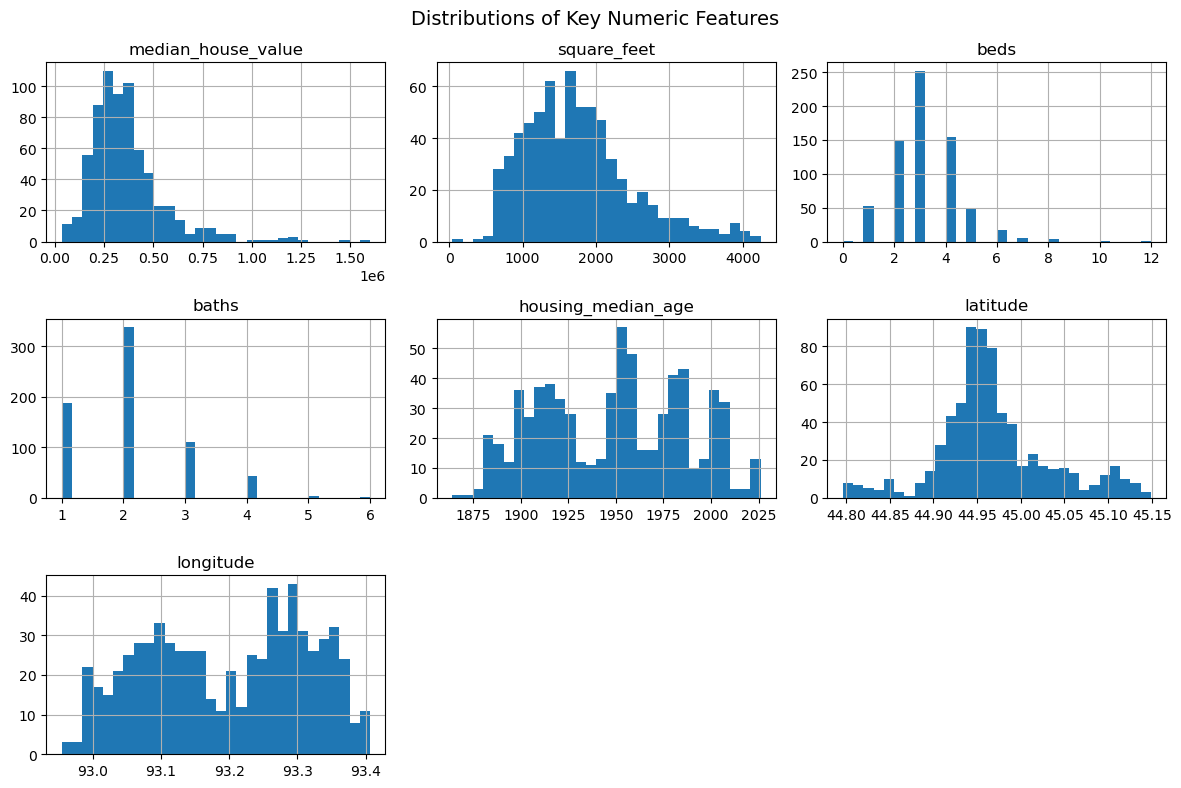

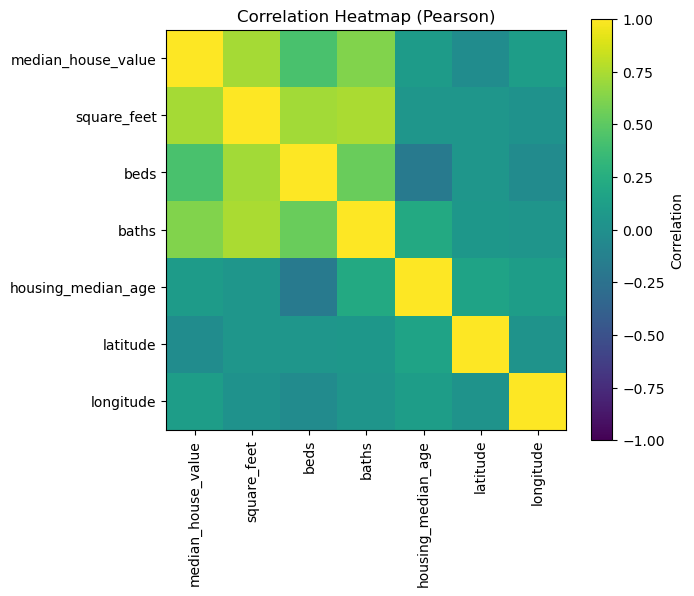

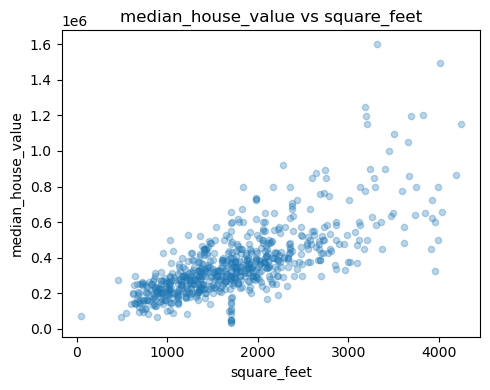

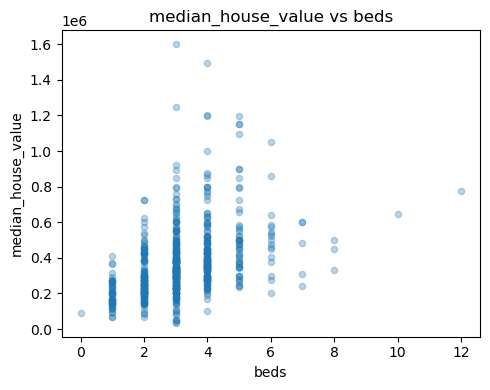

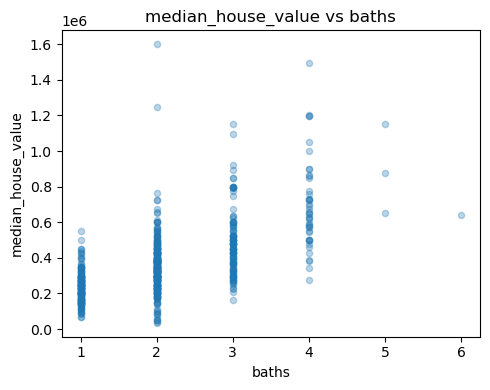

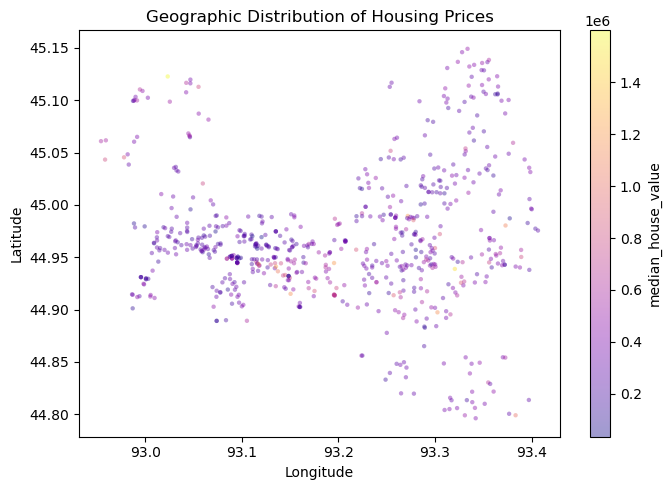

In [4]:
# Loading the cleaned dataset which has some pre cleaning done for EDA
df = pd.read_csv("housing_clean.csv")
print("Shape:", df.shape)
print("Columns:", list(df.columns))

# I am using these numeric columns to do some analysis on the dataset
num_cols = [c for c in ["median_house_value", "square_feet", "beds", "baths", 
                        "housing_median_age", "latitude", "longitude"] if c in df.columns]

# Using matplotlib to create histograms
if len(num_cols):
    df[num_cols].hist(bins=30, figsize=(12, 8))
    plt.suptitle("Distributions of Key Numeric Features", fontsize=14)
    plt.tight_layout(); plt.show()
else:
    print("No numeric columns for histograms.")

# Using matplotlib to create correlation heatmap
if len(num_cols) >= 2:
    corr = df[num_cols].corr()
    plt.figure(figsize=(7,6))
    plt.imshow(corr, vmin=-1, vmax=1)
    plt.colorbar(label="Correlation")
    plt.xticks(range(len(num_cols)), num_cols, rotation=90)
    plt.yticks(range(len(num_cols)), num_cols)
    plt.title("Correlation Heatmap (Pearson)")
    plt.tight_layout(); plt.show()
else:
    print("Not enough numeric columns for a correlation matrix.")

# Creating scatter plot for target variable median_house_value
target = "median_house_value"
predictors = [c for c in ["square_feet", "beds", "baths"] if c in df.columns]

for feat in predictors:
    df.plot(kind="scatter", x=feat, y=target, alpha=0.3, figsize=(5,4))
    plt.title(f"{target} vs {feat}")
    plt.tight_layout(); plt.show()

# Geographic price map using matplotlib
if {"longitude", "latitude"}.issubset(df.columns) and target in df.columns:
    geo = df[["longitude","latitude",target]].dropna().sample(n=min(5000, len(df)), random_state=42)
    plt.figure(figsize=(7,5))
    sc = plt.scatter(geo["longitude"], geo["latitude"], c=geo[target], cmap="plasma", alpha=0.4, s=10, edgecolor="none")
    plt.xlabel("Longitude"); plt.ylabel("Latitude")
    plt.title("Geographic Distribution of Housing Prices")
    plt.colorbar(sc, label=target)
    plt.tight_layout(); plt.show()



In [5]:
# Loading the cleaned data produced in Step 1 (EDA cleanup)
data = pd.read_csv("housing_clean.csv")

# I  am doing stratified split by income so that it keeps the income distribution similar in train and test splits
if "median_income" in data.columns:
    data["income_cat"] = pd.cut(
        data["median_income"],
        bins=[0., 1.5, 3., 4.5, 6., np.inf],
        labels=[1, 2, 3, 4, 5]
    )
    data = data.dropna(subset=["income_cat"])
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_idx, test_idx in sss.split(data, data["income_cat"]):
        train_set = data.iloc[train_idx].drop(columns=["income_cat"])
        test_set  = data.iloc[test_idx].drop(columns=["income_cat"])
else:
    # Fallback: simple random split if income is not available
    train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

# Separating features and target and creating training and test sets
assert "median_house_value" in train_set.columns, "Target 'median_house_value' missing."
X_train = train_set.drop(columns=["median_house_value"])
y_train = train_set["median_house_value"].copy()

X_test  = test_set.drop(columns=["median_house_value"])
y_test  = test_set["median_house_value"].copy()

# As per the requirement for this project I am adding some new features to the dataset
# If the required columns are present for the new features I am adding it else it will skip the addition.
# New features added: rooms_per_household, bedrooms_per_room and population_per_household
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    def safe_div(a, b):
        return np.where((b == 0) | pd.isna(b), np.nan, a / b)

    # rooms_per_household = total_rooms / households
    if {"total_rooms", "households"}.issubset(df.columns):
        df["rooms_per_household"] = safe_div(df["total_rooms"], df["households"])

    # bedrooms_per_room = total_bedrooms / total_rooms
    if {"total_bedrooms", "total_rooms"}.issubset(df.columns):
        df["bedrooms_per_room"] = safe_div(df["total_bedrooms"], df["total_rooms"])

    # population_per_household = population / households
    if {"population", "households"}.issubset(df.columns):
        df["population_per_household"] = safe_div(df["population"], df["households"])

    return df

# Wrapping feature engineering in a transformer so it can live inside a pipeline and be reused.
feature_adder = FunctionTransformer(add_features, validate=False, feature_names_out="one-to-one")

# Creating preprocessing pipelines
# Numeric pipeline: median imputation + standardization
numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical pipeline: most frequent imputation + one-hot encoding
categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# ColumnTransformer: apply numeric/ categorical pipelines to the right columns
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, selector(dtype_include=np.number)),
        ("cat", categorical_pipe, selector(dtype_include=["object", "string"]))
    ],
    remainder="drop"
)

# Base preprocessing pipeline to reuse in model training
base_preprocess = Pipeline([
    ("feat_add", feature_adder),
    ("prep", preprocess)
])

print(f"Train set shape: {X_train.shape}, Test set shape: {X_test.shape}")


Train set shape: (548, 12), Test set shape: (137, 12)


In [6]:
# Defining an evaluation function. This function computes Root Mean Squared Error (RMSE) using cross-validation.
# Parameters:
#   pipe : scikit-learn Pipeline (preprocessing + model)
#   X, y : training features and target
#   cv   : number of cross-validation folds (default=5)
def rmse_cv(pipe, X, y, cv=5):
    scores = cross_val_score(
        pipe,
        X, y,
        scoring="neg_mean_squared_error",  # returns negative MSE
        cv=cv,
        n_jobs=-1                         # run folds in parallel for speed
    )
    return np.sqrt(-scores)               # convert MSE → RMSE (positive values)


# Using base_preprocess which was defined in previous step for each models.
# This ensures data preprocessing happens *inside* CV folds,
# preventing data leakage and keeping training reproducible.
lin_pipe  = Pipeline([
    ("prep", base_preprocess),
    ("model", LinearRegression())
])

tree_pipe = Pipeline([
    ("prep", base_preprocess),
    ("model", DecisionTreeRegressor(random_state=42))
])

rf_pipe   = Pipeline([
    ("prep", base_preprocess),
    ("model", RandomForestRegressor(random_state=42))
])


# Evaluate each model using 5-fold CV on the training set.
# Report the mean and standard deviation of RMSE for stability.
for name, pipe in [
    ("Linear Regression", lin_pipe),
    ("Decision Tree", tree_pipe),
    ("Random Forest", rf_pipe)
]:
    scores = rmse_cv(pipe, X_train, y_train, cv=5)
    print(f"{name} | CV RMSE: mean={scores.mean():.2f}, std={scores.std():.2f}")

# Interpretation:
#   Lower mean RMSE → better performance
#   Smaller std → more consistent predictions across folds
# Systematically tests combinations of a few hand-picked parameters.
# This gives a small, deterministic search to find a good baseline.
grid_params = {
    "model__n_estimators": [150, 300],       # number of trees
    "model__max_depth": [None, 12, 20],      # depth of each tree
    "model__max_features": ["sqrt", 0.5],    # number of features per split
    "model__min_samples_split": [2, 5],      # min samples to split an internal node
    "model__min_samples_leaf": [1, 2]        # min samples required at a leaf node
}

grid = GridSearchCV(
    estimator=rf_pipe,
    param_grid=grid_params,
    scoring="neg_mean_squared_error",
    cv=5,
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train)
grid_rmse = np.sqrt(-grid.best_score_)

print("\n[GridSearchCV Results]")
print("Best parameters:", grid.best_params_)
print(f"Best CV RMSE: {grid_rmse:.2f}")


# Instead of testing all combinations, this samples random parameter sets.
rand_params = {
    "model__n_estimators": randint(200, 700),
    "model__max_depth": [None] + list(range(8, 28)),  # flexible depth range
    "model__max_features": uniform(0.3, 0.7),         # sample fraction of features
    "model__min_samples_split": randint(2, 12),
    "model__min_samples_leaf": randint(1, 5)
}

rand = RandomizedSearchCV(
    estimator=rf_pipe,
    param_distributions=rand_params,
    n_iter=40,                   # number of random parameter sets to test
    scoring="neg_mean_squared_error",
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)
rand.fit(X_train, y_train)
rand_rmse = np.sqrt(-rand.best_score_)

print("\n[RandomizedSearchCV Results]")
print("Best parameters:", rand.best_params_)
print(f"Best CV RMSE: {rand_rmse:.2f}")


# Compare the performance of both tuning methods and
# select the estimator with the lower cross-validated RMSE.

best_search = rand if rand_rmse <= grid_rmse else grid
best_model = best_search.best_estimator_

print("Best tuned model selected:",
      "RandomizedSearchCV" if best_search is rand else "GridSearchCV")


Linear Regression | CV RMSE: mean=123804.70, std=62542.51
Decision Tree | CV RMSE: mean=61027.52, std=5946.15
Random Forest | CV RMSE: mean=42723.03, std=10320.48
Fitting 5 folds for each of 48 candidates, totalling 240 fits

[GridSearchCV Results]
Best parameters: {'model__max_depth': None, 'model__max_features': 0.5, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 150}
Best CV RMSE: 60249.98
Fitting 5 folds for each of 40 candidates, totalling 200 fits

[RandomizedSearchCV Results]
Best parameters: {'model__max_depth': 18, 'model__max_features': np.float64(0.9576492590949324), 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 469}
Best CV RMSE: 43333.97
Best tuned model selected: RandomizedSearchCV


Final Test RMSE: 51203.04

Top feature importances:


,feature,importance
0,num__square_feet,0.579186
1,num__$/square_feet,0.367593
2,num__baths,0.019663
3,cat__property_type_Vacant Land,0.011688
4,num__days_on_market,0.005615
5,num__lot_size,0.003157
6,num__latitude,0.002953
7,num__longitude,0.002841
8,num__housing_median_age,0.002700
9,num__beds,0.001674


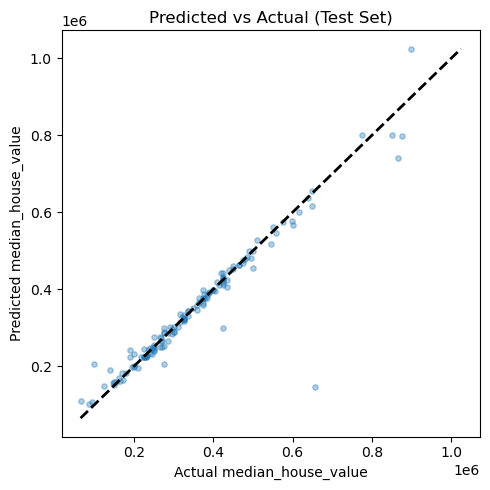

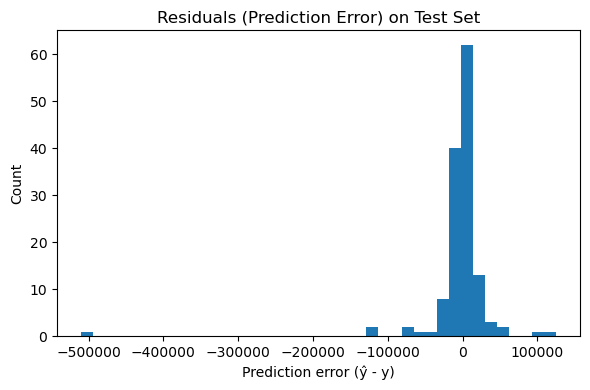

In [7]:
# Fit the best tuned model from the above step.
# I have fitted on X_train/y_train (NOT the full dataset) to keep the test set truly unseen for an 
# unbiased estimate of generalization error.
best_model.fit(X_train, y_train)

# Predict on the untouched test data
test_pred = best_model.predict(X_test)

# Root Mean Squared Error calculation
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
print(f"Final Test RMSE: {test_rmse:.2f}")

# Function to show feature importances for tree-based models.
def show_feature_importances(pipeline, top_n=20):
    try:
        # Final estimator (e.g., RandomForestRegressor)
        final_est = pipeline.named_steps["model"]
        if not hasattr(final_est, "feature_importances_"):
            print("Feature importances not available for this model (no `feature_importances_`).")
            return

        # Inside pipeline:
        # pipeline.named_steps["prep"]  -> base_preprocess (a Pipeline)
        #   ├─ "feat_add" -> FunctionTransformer (adds engineered features)
        #   └─ "prep"    -> ColumnTransformer (impute/scale/encode)
        base = pipeline.named_steps["prep"]
        feat_add = base.named_steps["feat_add"]
        coltx    = base.named_steps["prep"]

        # Fit the ColumnTransformer on the feature-engineered training data
        Xt_added = feat_add.transform(X_train)
        coltx.fit(Xt_added)
        feature_names = coltx.get_feature_names_out()

        importances = final_est.feature_importances_

        # Defensive alignment if something is off
        if len(importances) != len(feature_names):
            feature_names = [f"feat_{i}" for i in range(len(importances))]

        imp_df = (
            pd.DataFrame({"feature": feature_names, "importance": importances})
              .sort_values("importance", ascending=False)
              .head(top_n)
              .reset_index(drop=True)
        )
        print("\nTop feature importances:")
        display(imp_df)
        return imp_df
    except Exception as e:
        print("Could not compute feature importances:", e)

imp_df = show_feature_importances(best_model, top_n=20)

# Creating some diagnostic plots to show the feature importances.
# A) Predicted vs Actual — should cluster around the 45° line
plt.figure(figsize=(5,5))
plt.scatter(y_test, test_pred, alpha=0.35, s=15)
min_v = min(np.min(y_test), np.min(test_pred))
max_v = max(np.max(y_test), np.max(test_pred))
plt.plot([min_v, max_v], [min_v, max_v], 'k--', linewidth=2)  # 45° reference
plt.xlabel("Actual median_house_value")
plt.ylabel("Predicted median_house_value")
plt.title("Predicted vs Actual (Test Set)")
plt.tight_layout()
plt.show()

# B) Residuals histogram — should be centered near 0 (random noise)
residuals = test_pred - y_test
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=40)
plt.title("Residuals (Prediction Error) on Test Set")
plt.xlabel("Prediction error (ŷ - y)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [8]:
# I am saving the final, tuned pipeline for the assignment requirement i.e.
# 'best_model' is a Pipeline that contains:
#    - base_preprocess (feature engineering, imputation, scaling, encoding)
#    - the tuned estimator (e.g., RandomForest)
dump(best_model, "mn_housing_final_pipeline.joblib")
print("Saved model to mn_housing_final_pipeline.joblib")

# Creating a single synthetic 'new row' to demonstrate prediction this data is not seen by the model.
example = {}
for c in X_train.columns:
    if pd.api.types.is_numeric_dtype(X_train[c]):
        # numeric: use median as a neutral placeholder
        example[c] = float(pd.to_numeric(X_train[c], errors="coerce").median())
    else:
        # categorical: use most frequent category (fallback to empty string)
        non_na = X_train[c].dropna()
        example[c] = non_na.mode().iloc[0] if len(non_na) else ""

new_data = pd.DataFrame([example])

# Predicting with the saved pipeline
pred = best_model.predict(new_data)[0]
print(f"Example prediction (median_house_value): {pred:.2f}")

# Reloading the pipeline later and predicting again
loaded_pipe = load("mn_housing_final_pipeline.joblib")
pred2 = loaded_pipe.predict(new_data)[0]
print(f"Reloaded pipeline prediction: {pred2:.2f}")

Saved model to mn_housing_final_pipeline.joblib
Example prediction (median_house_value): 319381.27
Reloaded pipeline prediction: 319381.27
